### FIRS STEP
In this file, we are Reading and Cleaning the data, just in preparation to train and evaluate our models. Due to nature of this process, involving back and forth trial and errors in setting hyperparameters and cleaning data we're adding here libraries required to create and test our models to come up with our final model version.

This final trained version will be serialized and stored in folder ../trained_models. Then it will be deployed in our website to perform predictions for data entered by users.

In [83]:
from ucimlrepo import fetch_ucirepo # to pull dataset from uci repository, as a backup csv file is in the project folder /datasets.
import pandas as pd
from rfpimp import *
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
import sqlite3
import csv

# ------------------------------------------- HELPER FUNCTIONS ----------------------------------------------

# ------------------------------------------- EVALUATE FUNCTION ---------------------------------------------
# to prevent repeating code we created an evaluation function called evaluate # it will take features and
# target as parameters and use them to create and fit a random forest regressor model and calculate it's
# oob performance. It returns a tuple with rf model and its oob average from 10 runs
def evalReg(X,y,dt):
    oob_scores = []
    for i in range(10):
        rf = RandomForestRegressor(n_estimators=dt, n_jobs=-1, oob_score=True)
        rf.fit(X, y)
        oob_scores.append(rf.oob_score_)
    oob=sum(oob_scores) / len(oob_scores)
    print(f'Mean OOB score: {oob}')
    print(f'{rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height')
    return rf, oob

def evalClass(X,y,dt):
    oob_scores = []
    for i in range(10):
        rf = RandomForestClassifier(n_estimators=dt, n_jobs=-1, oob_score=True)
        rf.fit(X, y)
        oob_scores.append(rf.oob_score_)
    oob=sum(oob_scores) / len(oob_scores)
    print(f'Mean OOB score: {oob}')
    print(f'{rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height')
    return rf, oob
# ----------------------------------------- FEATURES IMPORTANCES --------------------------------------------
# showimp() show features importances, it accepts up to 4 params
# rf: a randomforest regressor
# X,y are the features and target
# features, I added this to perform different tests while converting non-numeric features
# plots the features' importances graphic
def showimp(rf,X,y):
    I=importances(rf,X,y)
    plot_importances(I,color='blue')
    return I

# --- we took this function from book, useful to quickly identify most obvious missing values in dataset ---
def sniff(df):
    # with pd.option_context("display.max_colwidth",20):
        info=pd.DataFrame()
        #info['sample']=df.iloc[120] #no needed here
        info['data type']=df.dtypes
        info['percent missing']=df.isnull().sum()*100/len(df)
        info['No. unique'] = df.apply(lambda x: len(x.unique()))
        info['unique values'] = df.apply(lambda x: x.unique())
        return info.sort_values('data type')

# ---------------- we'll use this many times during this lab, so we're saving keystrokes -------------------
def get_unique_values_in_columns(df):
     print('PRINTING UNIQUE VALUES PER COLUMN\n')
     for col in df.columns:
        print(f'{col} : {df[col].value_counts()} {df[col].unique()}')
        #  print(f'{col} : ')

#--------------------------------------- FUNCTIONS TO NORMALIZE --------------------------------------------
#                           missing values in numeric and non-numeric features
# NON-NUMERIC FEATURES: receives dataframe to normalize and a string with all values to replace
# and returns it 
def normalize_nonum(df,missing_values_str):   
    for col in df.columns:
        df[col]=df[col].str.lower()
        df[col]=df[col].fillna(np.nan)
        df[col]=df[col].replace(missing_values_str, np.nan)
    return df
# SET ALL VALUES IN NON-NUMERIC FEATURES TO LOWERCASE
def to_lower(df):   
    for col in df.columns:
        if is_object_dtype(df[col]):
            df[col]=df[col].str.lower()
    return df
    

# NUMERIC FEATURES: receives the dataframe to normalize and returns it
def normalize_num(df):
    for col in df.columns:
        df[col]=df[col].replace(0,np.nan)
    return df

# --------------------------------------- FUNCTIONS TO LABEL ENCODE -----------------------------------------
#                non-numeric features as ordinal, taken from book, this will fix missing values
# this converts dtype for each column to ordinal category.
def df_string_to_cat(df):
    for col in df.columns:
        if is_object_dtype(df[col]):
            df[col] = df[col].astype('category').cat.as_ordered()
    return df
# this loop transform nominal values in to integers according to categories previously assigned
def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1
    return df

# ------------------------- FUNCTION TO HANDLE MISSING VALUES ---------------------------
#                in numeric features based on the one showed in the book.
def fix_missing_num(df):
    r=df.isna().any()  # get the columns with missing values
    msvrows=r[r==True].index
    for e in msvrows:       #now loop through those columns and replace missing values with median
        df[e+'_na']=pd.isnull(df[e])
        df[e].fillna(df[e].median(), inplace=True)

In [93]:

obesity = fetch_ucirepo(id=544)
print (type(obesity))
# df=obesity.data.features
# df=pd.read_csv('./../datasets/ObesityDataSet_raw_and_data_sinthetic.csv')


<class 'ucimlrepo.dotdict.dotdict'>


In [103]:
df=obesity.metadata
df

{'uci_id': 544,
 'name': 'Estimation of Obesity Levels Based On Eating Habits and Physical Condition ',
 'repository_url': 'https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition',
 'data_url': 'https://archive.ics.uci.edu/static/public/544/data.csv',
 'abstract': 'This dataset include data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. ',
 'area': 'Health and Medicine',
 'tasks': ['Classification', 'Regression', 'Clustering'],
 'characteristics': ['Multivariate'],
 'num_instances': 2111,
 'num_features': 16,
 'feature_types': ['Integer'],
 'demographics': ['Gender', 'Age'],
 'target_col': ['NObeyesdad'],
 'index_col': None,
 'has_missing_values': 'no',
 'missing_values_symbol': None,
 'year_of_dataset_creation': 2019,
 'last_updated': 'Mon Feb 26 2024',
 'dataset_doi': '10.24432/C5H31Z',
 'creators': [],
 'intro_paper': 

In [ ]:
conn = sqlite3.connect('./../database/obesity.db')
cursor = conn.cursor()
df.to_sql('rawData', conn, if_exists='replace',index=False)


# sniff(df)
# df=df.drop((sniff(df)['No. unique']==1).loc[lambda x:x==True].index,axis=1)
# print(f'Dataset shape after removing features with one single value: {df.shape}')
# df=df.drop(['Low','High','index'],axis=1)
# get_unique_values_in_columns(df)
Xnum=df.select_dtypes(include="number")
# Xnum=Xnum.drop(['Weight'],axis=1)
y=df['NObeyesdad']
# num_features=Xnum.columns.tolist()
# [y.name]+num_features
# Xnum.columns
Xnum.to_sql('cleanData', conn, if_exists='replace',index=False)
Xnonum=df.drop(Xnum.columns.tolist() + [y.name],axis=1)

Mean OOB score: 0.9562766461392705
86,050 tree nodes and 18.0 median tree height


(2111, 17)

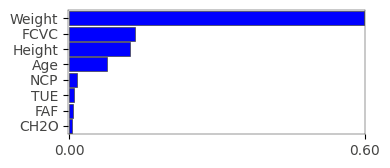

In [10]:
rfbl,oob1=evalClass(Xnum,y,150)
showimp(rfbl,Xnum,y)
df.shape

In [9]:

pd.read_sql_query('select * from cleanData',conn).sample(15)

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
879,19.726522,1.508267,61.104030,2.778079,3.000000,1.696691,0.942240,0.879925
1772,25.012770,1.788586,117.849351,2.191108,2.993856,2.444917,1.055854,0.145284
655,18.915050,1.633316,45.000000,3.000000,3.000000,2.924594,1.352558,0.220087
615,20.345161,1.534385,41.965250,2.888530,1.000000,1.000000,0.000000,0.196224
169,45.000000,1.630000,77.000000,2.000000,3.000000,1.000000,0.000000,0.000000
759,35.125401,1.529834,62.903938,2.000000,2.105616,1.456581,0.000000,0.997400
1187,35.719457,1.685947,83.325800,2.000000,1.009426,2.136398,1.060349,0.000000
1460,23.000000,1.742500,105.028665,2.393837,3.000000,2.014990,0.978815,0.413220
1113,18.000000,1.742819,86.565148,3.000000,3.000000,2.000000,2.040816,0.860321
827,38.943282,1.554728,63.011645,2.869436,3.000000,2.972426,2.160790,0.305954


In [6]:
Xnum.info()
# conn.commit() # save changes
conn.close()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     2111 non-null   float64
 1   Height  2111 non-null   float64
 2   Weight  2111 non-null   float64
 3   FCVC    2111 non-null   float64
 4   NCP     2111 non-null   float64
 5   CH2O    2111 non-null   float64
 6   FAF     2111 non-null   float64
 7   TUE     2111 non-null   float64
dtypes: float64(8)
memory usage: 132.1 KB


In [ ]:

rfbl.predict([[28,1.9,1,5,1.5,3,1]])

In [ ]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import datasetss

# import matplotlib.pyplot as plt

# url = "http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
# df = pd.read_csv(url)
#set vector and target features
# X=df.iloc[:,0:4]
# y=df.iloc[:,4]

#creating model
# model=LogisticRegression(multi_class='auto')

#accuracy metrics
# iris=datasets.load_iris()
# X=iris.data
# y=iris.target
kfold=model_selection.KFold(n_splits=10,random_state=7, shuffle=True)
scoring='accuracy'
#getting accuracy on validation
results=model_selection.cross_val_score(rfbl,Xnum,y,cv=kfold,scoring=scoring)
print(f'Accuracy -val set: {results.mean()*100} ({results.std()})')

X_train, X_test, y_train, y_test = model_selection.train_test_split(Xnum, y, test_size=0.2, random_state=7)
rfbl.fit(X_train,y_train)
pred=rfbl.predict(X_test)

result=rfbl.score(X_test,y_test)
print(f'Accuracy - test set: {result*100}')

# #Construct the Confusion Matrix
# labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
# labels
# cm = confusion_matrix(y_test, pred, labels=labels)
# print(cm)
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(cm)
# plt.title('Confusion matrix')
# fig.colorbar(cax)
# ax.set_xticklabels([''] + labels)
# ax.set_yticklabels([''] + labels)
# plt.xlabel('Predicted Values')
# plt.ylabel('Actual Values')
# plt.show()

In [ ]:
import joblib
from pathlib import Path
jl_filedir = Path("trained_models")
jl_filedir.mkdir(parents=True,exist_ok=True)

jl_filepath=jl_filedir / 'model.joblib'

joblib.dump(model,jl_filepath)

model_jl=joblib.load(jl_filepath)
assert (model.coef_ == model_jl.coef_).all()